In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.structured import *
from fastai.column_data import *

PATH = 'data/hackerearth-zs/'

In [2]:
import pandas as pd

In [3]:
df_given = pd.read_csv(PATH+'yds_train2018.csv',low_memory=False)

In [4]:
df_given.head()

,S_No,Year,Month,Week,Merchant_ID,Product_ID,Country,Sales
0,1,2013,1,1,ar00001,1,Argentina,157500.0
1,2,2013,1,1,ar00003,1,Argentina,39375.0
2,3,2013,1,1,ar00004,1,Argentina,15750.0
3,4,2013,1,1,ar00007,1,Argentina,47250.0
4,5,2013,1,1,ar00008,1,Argentina,283500.0


In [5]:
len(df_given)

79072

In [6]:
df_given.drop('Week',inplace=True,axis=1)

In [7]:
df_given.head()

,S_No,Year,Month,Merchant_ID,Product_ID,Country,Sales
0,1,2013,1,ar00001,1,Argentina,157500.0
1,2,2013,1,ar00003,1,Argentina,39375.0
2,3,2013,1,ar00004,1,Argentina,15750.0
3,4,2013,1,ar00007,1,Argentina,47250.0
4,5,2013,1,ar00008,1,Argentina,283500.0


In [8]:
df_temp = df_given.groupby(['Year','Month','Merchant_ID','Product_ID','Country']).sum().reset_index()


In [9]:
df_temp.head()

,Year,Month,Merchant_ID,Product_ID,Country,S_No,Sales
0,2013,1,ar00001,1,Argentina,293,551250.00
1,2013,1,ar0000100,1,Argentina,355,239400.00
2,2013,1,ar0000100,2,Argentina,10441,26230.82
3,2013,1,ar0000102,1,Argentina,150,3150.00
4,2013,1,ar0000102,2,Argentina,10476,16692.34


In [10]:
df_temp.drop('S_No',inplace=True,axis=1)

In [11]:
len(df_temp)

36058

In [12]:
df_temp.to_csv(PATH+'to_save.csv')

In [13]:
df_temp.head()

,Year,Month,Merchant_ID,Product_ID,Country,Sales
0,2013,1,ar00001,1,Argentina,551250.00
1,2013,1,ar0000100,1,Argentina,239400.00
2,2013,1,ar0000100,2,Argentina,26230.82
3,2013,1,ar0000102,1,Argentina,3150.00
4,2013,1,ar0000102,2,Argentina,16692.34


In [14]:
df_experi = df_temp.groupby(['Year','Month','Merchant_ID','Product_ID','Country']).sum().reset_index()

In [15]:
df_experi.head()

,Year,Month,Merchant_ID,Product_ID,Country,Sales
0,2013,1,ar00001,1,Argentina,551250.00
1,2013,1,ar0000100,1,Argentina,239400.00
2,2013,1,ar0000100,2,Argentina,26230.82
3,2013,1,ar0000102,1,Argentina,3150.00
4,2013,1,ar0000102,2,Argentina,16692.34


In [16]:
x,y = np.unique(df_temp['Merchant_ID'],return_counts=True)

In [17]:
df_given_expenses = pd.read_csv(PATH+'promotional_expense_1.csv',low_memory=False)

In [18]:
len(df_experi)

36058

In [19]:
df_joined = pd.merge(df_experi,df_given_expenses,how='left',left_on=['Year','Month','Country','Product_ID'],right_on=['Year','Month','Country','Product_ID'])

In [20]:
df_joined.tail()

,Year,Month,Merchant_ID,Product_ID,Country,Sales,Expense_Price
36053,2016,12,c000075,3,Columbia,74200.0,NaN
36054,2016,12,c000087,3,Columbia,38584.0,NaN
36055,2016,12,c000089,3,Columbia,29680.0,NaN
36056,2016,12,c00009,3,Columbia,2226.0,NaN
36057,2016,12,c000093,3,Columbia,7420.0,NaN


In [21]:
df_joined.replace(to_replace=0,value=0.1,inplace=True)

In [22]:
df_joined = df_joined.fillna(0)

In [23]:
df_joined.to_csv(PATH+'final_training.csv')

In [24]:
df_joined.head()

,Year,Month,Merchant_ID,Product_ID,Country,Sales,Expense_Price
0,2013,1,ar00001,1,Argentina,551250.00,14749.307
1,2013,1,ar0000100,1,Argentina,239400.00,14749.307
2,2013,1,ar0000100,2,Argentina,26230.82,1329.374
3,2013,1,ar0000102,1,Argentina,3150.00,14749.307
4,2013,1,ar0000102,2,Argentina,16692.34,1329.374


In [25]:
cat_vars=['Merchant_ID','Product_ID','Country','Month']

In [26]:
cont_vars = ['Year','Sales','Expense_Price']

In [27]:
for v in cat_vars:
    df_joined[v] = df_joined[v].astype('category').cat.as_ordered()

In [28]:
for v in cont_vars:
    df_joined[v] = df_joined[v].astype('float32')

In [29]:
n = len(df_joined); n

36058

In [30]:
idxs = get_cv_idxs(n, val_pct=6000/n)


In [31]:
df, y,nas, mapper = proc_df(df_joined, 'Sales', do_scale=True)

In [32]:
np.min(y)

-1396585.6

In [33]:
y = y+1396590

In [34]:
ylog = np.log(y)

In [35]:
for c in cat_vars:
    df[c]= df[c].astype('category').cat.as_ordered()

In [36]:
for c in cat_vars:
    print(df[c].dtype)

category
category
category
category


In [37]:
md = ColumnarModelData.from_data_frame(PATH, idxs, df, ylog.astype(np.float32), cat_flds=cat_vars, bs=128,test_df=None, is_reg=True)

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
((val,trn), (y_val,y_trn)) = split_by_idx(idxs, df.values, ylog)

In [40]:
m = RandomForestRegressor(n_estimators=6000)
m.fit(trn, y_trn);

In [41]:
preds = m.predict(val)


In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
m.score(trn, y_trn), m.score(val, y_val), mean_absolute_percentage_error(y_val, preds)

(0.9774301532643402, 0.9452170444200183, 0.10945125604415905)

In [44]:
y_val[10:100]

array([14.17185, 14.19298, 14.15295, 14.1519 , 14.15894, 14.15298, 14.16207, 14.15871, 14.15566, 14.21388,
       14.15526, 14.16417, 14.15183, 14.15016, 14.15016, 14.152  , 14.15138, 14.16094, 14.152  , 14.15077,
       14.15627, 14.15069, 14.15023, 14.15159, 14.14954, 14.15295, 14.15069, 14.15091, 14.15023, 14.15566,
       14.18112, 14.15505, 14.16996, 14.15871, 14.1598 , 14.15639, 14.17679, 14.16658, 14.1738 , 14.1632 ,
       14.15138, 14.15639, 14.15412, 14.15639, 14.15566, 14.15298, 14.15183, 14.17444, 14.16658, 14.152  ,
       14.16433, 14.15363, 14.15077, 14.15138, 14.16417, 14.15077, 14.15639, 14.15016, 14.15016, 14.16296,
       14.15867, 14.18393, 14.15639, 14.15749, 14.15016, 14.15688, 14.15183, 14.14954, 14.15298, 14.18444,
       14.15322, 14.15444, 14.15261, 14.156  , 14.15616, 14.21084, 14.1854 , 14.18525, 14.14954, 14.21084,
       14.07165, 14.14954, 14.18814, 14.14954, 14.21084, 14.14954, 14.15616, 14.21084, 14.21084, 14.14976])

In [45]:
preds[10:100]

array([14.71771, 14.16578, 14.15936, 14.15162, 14.15425, 14.15645, 14.16256, 14.16004, 14.16345, 14.19614,
       14.16482, 14.15457, 14.15259, 14.15106, 14.15136, 14.15311, 14.153  , 14.15605, 14.15208, 14.15117,
       14.15444, 14.15408, 14.15301, 14.15033, 14.14929, 14.1525 , 14.15201, 14.15556, 14.15063, 14.15798,
       14.17757, 14.15415, 14.17581, 14.16193, 14.16542, 14.15873, 14.16823, 14.16412, 14.1674 , 14.16331,
       14.15158, 14.16097, 14.15413, 14.15423, 14.15469, 14.15192, 14.15455, 14.17166, 14.16615, 14.15101,
       14.16042, 14.15222, 14.15135, 14.15379, 14.15884, 14.1526 , 14.15905, 14.15064, 14.15025, 14.16905,
       14.15894, 14.17158, 14.15608, 14.15895, 14.15194, 14.15237, 14.15493, 14.15486, 14.15624, 14.18136,
       14.15234, 14.15791, 14.15329, 14.16537, 14.18014, 14.16429, 14.21727, 14.18419, 14.14955, 14.15078,
       14.04332, 14.1885 , 14.21778, 14.20125, 14.16536, 12.58851, 14.17137, 14.54579, 14.35103, 14.14988])

In [46]:
df.to_csv(PATH+'training_set_converted.csv')

In [47]:
df_test = pd.read_csv(PATH+'yds_test2018.csv',low_memory=False)

df_test.head()

df_given.head()

df_test.drop(['S_No'],inplace=True,axis=1)

df_merchants = df_given[['Merchant_ID','Country']]

df_merchants

df_test.head()

df_test.head()

df_merchants.head()

temp=np.unique(df_merchants['Merchant_ID'])

final_merchants = df_merchants.drop_duplicates(keep='first')

final_merchants.head()

df_test_experiment=df_test.merge(final_merchants,on=['Country'],how='left')

df_test_experiment.to_csv(PATH+'experiment.csv')

len(df_test)

105*1800

df_test_experiment.head()

df_test_joined = pd.merge(df_test_experiment,df_given_expenses,how='left',left_on=['Year','Month','Country','Product_ID'],right_on=['Year','Month','Country','Product_ID'])

df_test_joined.head()



df_test_joined = df_test_joined.fillna(0)

for c in cat_vars:
    df_test_joined[c]= df_test_joined[c].astype('category').cat.as_ordered()

df_test, _, nas, mapper = proc_df(df_test_joined, 'Sales', do_scale=True,
                                  mapper=mapper, na_dict=nas)

df_test.head()

,Year,Month,Product_ID,Country,Merchant_ID,Expense_Price
0,1.811337,4,1,1,2,-0.10325
1,1.811337,4,1,1,40,-0.10325
2,1.811337,4,1,1,51,-0.10325
3,1.811337,4,1,1,84,-0.10325
4,1.811337,4,1,1,94,-0.10325


In [48]:
df_test.to_csv(PATH+'test_with_converted.csv')

In [49]:
x,y=np.unique(df_test['Merchant_ID'],return_counts=True)

In [50]:
df_proper_this = df_test

In [51]:
df_proper_this.tail()

,Year,Month,Product_ID,Country,Merchant_ID,Expense_Price
33931,1.811337,7,4,6,1735,-0.484604
33932,1.811337,7,4,6,1786,-0.484604
33933,1.811337,7,4,6,1728,-0.484604
33934,1.811337,7,4,6,1730,-0.484604
33935,1.811337,7,4,6,1732,-0.484604


In [52]:
df.head()

,Year,Month,Merchant_ID,Product_ID,Country,Expense_Price
0,-1.239963,1,2,1,1,0.237421
1,-1.239963,1,4,1,1,0.237421
2,-1.239963,1,4,2,1,-0.462223
3,-1.239963,1,6,1,1,0.237421
4,-1.239963,1,6,2,1,-0.462223


In [53]:
t_x,t_y = np.unique(df['Merchant_ID'],return_counts=True)

In [54]:
dict(zip(t_x,t_y))

{1: 5,
 2: 24,
 3: 43,
 4: 93,
 5: 1,
 6: 20,
 7: 5,
 8: 1,
 9: 13,
 10: 68,
 11: 34,
 12: 72,
 13: 45,
 14: 96,
 15: 15,
 16: 28,
 17: 1,
 18: 5,
 19: 4,
 20: 2,
 21: 100,
 22: 17,
 23: 80,
 24: 74,
 25: 92,
 26: 3,
 27: 23,
 28: 33,
 29: 55,
 30: 7,
 31: 66,
 32: 2,
 33: 39,
 34: 13,
 35: 4,
 36: 1,
 37: 11,
 38: 74,
 39: 20,
 40: 33,
 41: 52,
 42: 6,
 43: 26,
 44: 15,
 45: 84,
 46: 1,
 47: 41,
 48: 74,
 49: 97,
 50: 84,
 51: 51,
 52: 99,
 53: 78,
 54: 40,
 55: 90,
 56: 97,
 57: 1,
 58: 39,
 59: 1,
 60: 37,
 61: 1,
 62: 1,
 63: 7,
 64: 71,
 65: 97,
 66: 46,
 67: 44,
 68: 70,
 69: 40,
 70: 48,
 71: 37,
 72: 83,
 73: 1,
 74: 39,
 75: 1,
 76: 22,
 77: 79,
 78: 62,
 79: 44,
 80: 36,
 81: 2,
 82: 60,
 83: 25,
 84: 49,
 85: 57,
 86: 14,
 87: 1,
 88: 3,
 89: 51,
 90: 28,
 91: 39,
 92: 3,
 93: 76,
 94: 24,
 95: 12,
 96: 2,
 97: 3,
 98: 2,
 99: 1,
 100: 3,
 101: 2,
 102: 7,
 103: 1,
 104: 4,
 105: 6,
 106: 2,
 107: 12,
 108: 2,
 109: 1,
 110: 1,
 111: 2,
 112: 2,
 113: 35,
 114: 2,
 115: 37,


In [55]:
test = dict(zip(t_x,t_y))

In [56]:
df_test.head()

,Year,Month,Product_ID,Country,Merchant_ID,Expense_Price
0,1.811337,4,1,1,2,-0.10325
1,1.811337,4,1,1,40,-0.10325
2,1.811337,4,1,1,51,-0.10325
3,1.811337,4,1,1,84,-0.10325
4,1.811337,4,1,1,94,-0.10325


In [57]:
df.head()

,Year,Month,Merchant_ID,Product_ID,Country,Expense_Price
0,-1.239963,1,2,1,1,0.237421
1,-1.239963,1,4,1,1,0.237421
2,-1.239963,1,4,2,1,-0.462223
3,-1.239963,1,6,1,1,0.237421
4,-1.239963,1,6,2,1,-0.462223


In [58]:
df_test_reordered  = df_test[['Year','Month','Merchant_ID','Product_ID','Country','Expense_Price']]

In [59]:
predictions_for_al = m.predict(df_test_reordered)

In [60]:
df_test['Sales']=predictions_for_al

In [61]:
df_test.to_csv(PATH+'with_converted_results.csv')

In [62]:
y_trn

array([14.48223, 14.30776, 14.16815, ..., 14.17057, 14.15114, 14.15484])

In [63]:
val

array([[-1.239963173866272, 1, 6, 2, 1, -0.4622231721878052],
       [-1.239963173866272, 1, 14, 1, 1, 0.23742064833641052],
       [-1.239963173866272, 1, 25, 1, 1, 0.23742064833641052],
       ...,
       [1.8113369941711426, 12, 635, 3, 3, -0.5315296649932861],
       [1.8113369941711426, 12, 739, 3, 3, -0.5315296649932861],
       [1.8113369941711426, 12, 760, 3, 3, -0.5315296649932861]], dtype=object)

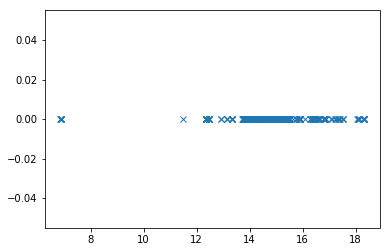

In [64]:
import numpy as np
import matplotlib.pyplot as pp
val = 0. # this is the value where you want the data to appear on the y-axis.
ar = predictions_for_al
pp.plot(ar, np.zeros_like(ar) + val, 'x')
pp.show()

In [65]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

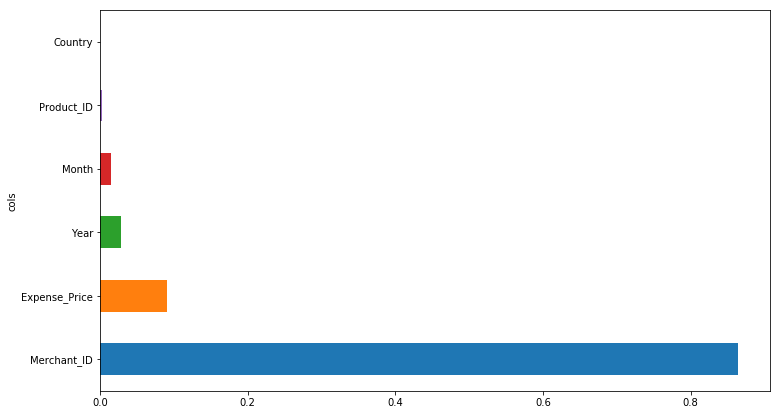

In [66]:
fi = rf_feat_importance(m, df)
plot_fi(fi);

In [67]:
df_test_reordered['Sales']=predictions_for_al

In [68]:
df_test_reordered.to_csv(PATH+'final_convereted.csv')

In [69]:
df_test_reordered.head()

,Year,Month,Merchant_ID,Product_ID,Country,Expense_Price,Sales
0,1.811337,4,2,1,1,-0.10325,14.320488
1,1.811337,4,40,1,1,-0.10325,14.202502
2,1.811337,4,51,1,1,-0.10325,14.195200
3,1.811337,4,84,1,1,-0.10325,14.227575
4,1.811337,4,94,1,1,-0.10325,14.390186


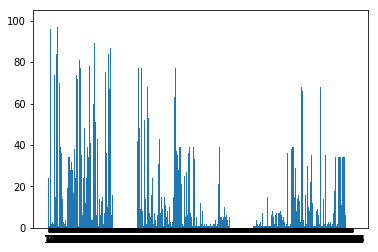

In [70]:
import matplotlib.pyplot as plt

D = test

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))

plt.show()

In [71]:
len(t_y[t_y>10])

788

In [72]:
df_backup = df_test_reordered

In [73]:
df_backup.head()

,Year,Month,Merchant_ID,Product_ID,Country,Expense_Price,Sales
0,1.811337,4,2,1,1,-0.10325,14.320488
1,1.811337,4,40,1,1,-0.10325,14.202502
2,1.811337,4,51,1,1,-0.10325,14.195200
3,1.811337,4,84,1,1,-0.10325,14.227575
4,1.811337,4,94,1,1,-0.10325,14.390186


In [74]:
df_test_reordered=df_backup

In [75]:
df_test_reordered['Sales']= np.exp(df_test_reordered['Sales'])-1396590

In [76]:
df_test_reordered.to_csv(PATH+'reorder_temp.csv')

In [77]:
count=0
for i,row in df_test_reordered.iterrows():
    if(test[row['Merchant_ID']]<12):
        df_test_reordered.loc[i,'Sales']=0
        count= count+1
count

17322

In [78]:
df_need = df_test_reordered[['Year','Month','Product_ID','Country','Sales']]

In [79]:
df_need.head()

,Year,Month,Product_ID,Country,Sales
0,1.811337,4,1,1,260358.606330
1,1.811337,4,1,1,75953.358408
2,1.811337,4,1,1,65240.469380
3,1.811337,4,1,1,113342.383073
4,1.811337,4,1,1,379963.399005


In [80]:
df_result =  df_need.groupby(['Year','Month','Product_ID','Country']).sum().reset_index()


In [81]:
len(df_result)

105

In [82]:
df_result.to_csv(PATH+'final_winning.csv')

In [83]:
df_result.head()

,Year,Month,Product_ID,Country,Sales
0,0.794237,11,4,5,1.786733e+05
1,0.794237,11,4,6,2.862061e+07
2,0.794237,11,5,5,7.132236e+05
3,0.794237,12,4,5,2.345569e+05
4,0.794237,12,4,6,3.186008e+07
